In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle

Functions for saving/loading objects

In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

 # Newton-Cotes-Quadrature

## Definitions

In [3]:
omega = 2
#PI    = np.arccos(-1) # Funktioniert auch in C++ oder Fortran am besten so!
PI = np.pi  # so ists aber in Python schneller...
Tmin  = 0
Tmax  = PI/2   # Intervallbreite festlegen
N = 100


## a) Function and interval

In [4]:
def f(t): 
    return np.sin(omega*t)

T = np.linspace(Tmin, Tmax, N+1)

## Exact integral

"Exact" -> Here I am using scipy's quad function.

$
\int_{t=0}^{\pi/2} f(t) dt = \int_{t=0}^{\pi/2} sin (wt) dt =
$

In [5]:
from scipy import integrate
result, errorbound = integrate.quad(f, Tmin, Tmax)
print("result = {}".format(result))
print("max error = {}".format(errorbound))

I_ex = result

result = 1.0
max error = 1.1102230246251565e-14


## Polynomial integration

![images/integratepolyomial.png](images/integratepolyomial.png)

The integral $ \int_{a}^b t^i dt $ can be calculated easily in the form $ \frac{1}{i+1} \left( b^{i+1} - a^{i+1} \right) $, for example:

$
 i = 2: \int_{a}^b t^2 dt = \frac{1}{2+1} \left( b^{2+1} - a^{2+1} \right) = \frac{b^{3}}{3} - \frac{a^{3}}{3}
 $

In [6]:
def integrate_polynomial(p, a, b):
    """ 
    Calculate the exact integral of a polynomial p over bounds (a,b)
    The polynomial is given by a coefficient vector, as in:
    p(x) = 3 + 2x + x³
    coefficients = [3,2,1]
    """
    t_integrals = np.array([(1/(i+1)) * (b**(i+1) - a**(i+1))
                            for i in range(len(p))])
    return sum(p * t_integrals)
       
    
p = np.array([ 0, 1, 0, 0, -1 ])
assert integrate_polynomial(p, 0, 1) == 0.3

## Calculate weights for NC

The coefficients (weights) for the Newton-Cotes Quadrature $\lambda_i$ are calculated from the Langragian interpolation polynomials, which have the form 
$ L_i(x) = \prod_{i \ne j} \frac{x - x_j}{x_i - x_j} .$

The interpolating polynomial for a function f(x) is 
$ L(x) = \sum_i f(x_i) L_i $.

Therefore, the weights are calculated as follows:

$
\lambda_i = \frac{1}{t_N - t_0} \int_{t_0}^{t_N} \prod_{i \ne j} \frac{t - t_j}{t_i - t_j} dt
$

For the Netwon-Cotes quadrature
![](images/newtoncotes.png)

the following block calculates a dictionary of NC-Weights **on a reference interval (0,1)** similar to the form:
![images/lambdamatrix.png](images/lambdamatrix.png)

In [7]:
def calc_and_store_NC_weights(maxcoeffs = 7):

    # referenzintervall
    t_min = 0
    t_max = 1.0

    all_coeffs = {}

    for n in range(2,maxcoeffs+1):
        coeffs = np.zeros(n) 

        T = np.linspace(t_min,t_max,n)

        for i in range(0, n):

            ti = T[i]

            p = np.array([1])
            for j in range(len(T)):
                if not i == j:
                    tj = T[j]
                    a = 1/(ti - tj)
                    p_ = a * np.array([-tj, 1]) # a*(t-t_j)
                    p = np.convolve(p, p_)  # polynomial multiplication

            c = 1/(t_max - t_min) * integrate_polynomial(p, t_min, t_max) 
            assert c > 0
            coeffs[i] = c
        all_coeffs[n] = coeffs

    save_obj(all_coeffs, "ub8_nc_weights")

In [13]:
def quad_NC(f, a,b, N):
    """
    Apprimate the integral of any (callable) function f
    on the interval a,b
    using Newton-Cotes Quadrature with N support points.
    The weights are loaded for the reference interval
    and must be transformed to the function interval.
    """
    try:
        weights = load_obj("ub8_nc_weights")[N]
    except KeyError as e:
        print("Weights for N={} not available".format(N))
        return
    weights = weights[:N]  # only the first N, rest are 0
    support_points = np.linspace(a,b,N)
    
    function_values = [f(ti) for ti in support_points]
    
    
    #print("function values")
    #print(function_values)
    #print("weights")
    #print(weights)
    
    
    return (b-a) * sum(weights*function_values)

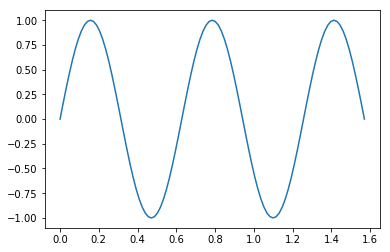

order 2, I=4.809176734304475e-16
order 3, I=1.047197551196598
order 4, I=-1.0202621423817464
order 5, I=-0.5804063454332812
order 6, I=-5.3435297047828166e-17
order 7, I=0.8251068252670467


In [14]:
omega = 10
plt.plot(T, f(T))
plt.show()

calc_and_store_NC_weights()
for n in range(2,8):
    print("order {}, I={}".format(n, quad_NC(f, Tmin, Tmax, n)))